# Definitions 

In [1]:
from tensorsketch import * 

from autofaiss import build_index
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("paper")

# Experiment 

In [146]:
num_samples = 5000              #@param {type:"integer",min:100,step:100}
seq_len = 100                  #@param {type:"integer"}
alphabet_size = 4               
m = 50                          # number of rates, producing a grid over (0,1)   
compute_edit_distance = False   #@param{type:"boolean"}
samples, rates = gen_seqs(N=seq_len,
                          A=alphabet_size,
                          num_samples=num_samples,
                          num_rates=m)

n, m, l = samples.shape
seqs = samples.reshape((-1,l))
pairs = np.array([(i*m,i*m+j+1) for i in range(n) for j in range(m-1)])

if compute_edit_distance:
    ed_dists = edit_dist_pairs(pairs,seqs,edit_dist)
    ed_dists = ed_dists.reshape((n,m-1))

generating seqs : 100%|██████████| 10000/10000 [00:12<00:00, 795.79it/s]


In [147]:
kmer_size = 8               #@param {type:"slider",min:1,max:32,step:1}
tuple_size = 3              #@param {type:"slider",min:1,max:10,step:1}
sketch_dim = 100            #@param {type:"slider",min:10,max:1000,step:10} 
run_cuda_models = True        #@param {type:"boolean"}    

stride_ratio = 0.1          
window_ratio = 0.2     

stride = int(stride_ratio*seq_len)
window = int(window_ratio*seq_len)

common = dict(A=alphabet_size,D=sketch_dim,normalize=False)

models = {
    # 'MH': MH(k=kmer_size, **common),
    # 'TE': TE(t=tuple_size, A=alphabet_size),
    # 'TS': TS(t=tuple_size,  **common),
    'TSS': TSS(t=tuple_size, S=stride, seq_len=seq_len, W=window, **common),
}
all_sketches = {name:model.sketch(seqs) for name,model in models.items()}

In [148]:
sketches = all_sketches['TSS']
sketches = np.array(sketches)
# sketches = sketches/np.linalg.norm(sketches,axis=1)[:,np.newaxis]

len(sketches) / 1e6

0.51

In [149]:

index, index_infos = build_index(sketches.astype(np.float32),metric_type='l2', save_on_disk=False)


2022-07-27 22:35:12,960 [INFO]: Using 24 omp threads (processes), consider increasing --nb_cores if you have more
2022-07-27 22:35:13,080 [INFO]: Launching the whole pipeline 07/27/2022, 22:35:13
2022-07-27 22:35:13,081 [INFO]: Reading total number of vectors and dimension 07/27/2022, 22:35:13
100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]
2022-07-27 22:35:13,098 [INFO]: There are 510000 embeddings of dim 117
2022-07-27 22:35:13,099 [INFO]: >>> Finished "Reading total number of vectors and dimension" in 0.0175 secs
2022-07-27 22:35:13,099 [INFO]: 	Compute estimated construction time of the index 07/27/2022, 22:35:13
2022-07-27 22:35:13,100 [INFO]: 		-> Train: 16.7 minutes
2022-07-27 22:35:13,101 [INFO]: 		-> Add: 0.7 seconds
2022-07-27 22:35:13,101 [INFO]: 		Total: 16.7 minutes
2022-07-27 22:35:13,102 [INFO]: 	>>> Finished "Compute estimated construction time of the index" in 0.0016 secs
2022-07-27 22:35:13,102 [INFO]: 	Checking that your have enough memory available to create the in

In [150]:
%%time
D,I = index.search(sketches[::(len(rates)+1)].astype(np.float32),200)

CPU times: user 4min 13s, sys: 611 ms, total: 4min 13s
Wall time: 11.4 s


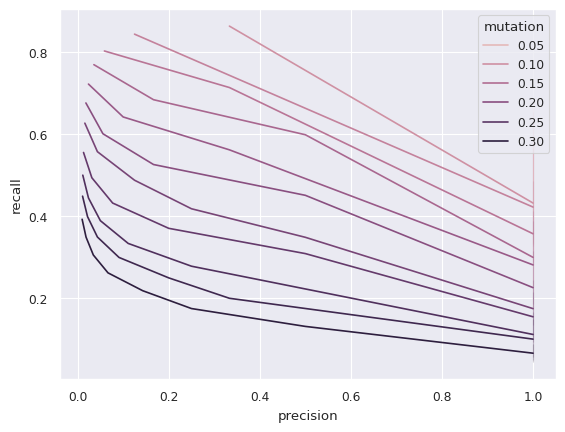

In [186]:

starts = np.arange(0,len(sketches),len(rates)+1)
diffs = I - starts[:,np.newaxis]
FP = (diffs<0)|(diffs>len(rates))
TP = ~FP 
FP = np.cumsum(FP,1)
ds = np.unique(diffs[TP])
df = pd.DataFrame(columns=['mutation','recall','precision'])
for d,mr in list(zip(ds,rates))[:15:]:
    for q in np.arange(.1,1,.1):
        
        fp = np.quantile(FP[diffs==d],q=q)
        recall = np.sum(diffs==d)*q / len(diffs)
        p = 1/(1+fp)
        df.loc[len(df),:] = (mr,recall,p)
        # print(f'mutation= {mr:.2f}\t R={recall:.2f}\t P = {p:.3f}')
sns.lineplot(data=df,x='precision',y='recall',hue='mutation')
plt.show()

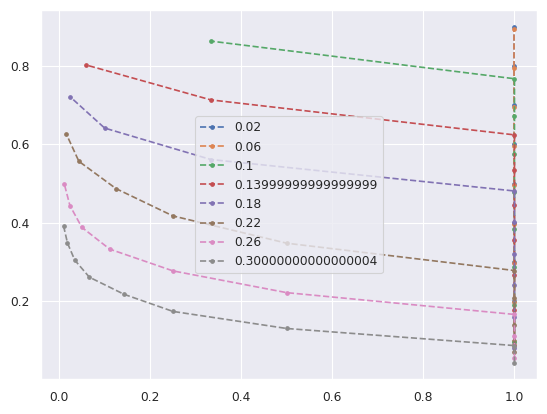

In [189]:
mrs = df['mutation'].unique().tolist()[::2]
for mr in mrs:
    sdf = df.loc[df.mutation==mr]
    plt.plot(sdf['precision'],sdf['recall'],'--.',)
plt.legend(mrs)
plt.show()
